## Carregamento dos Dados e Preparação do Ambiente

### Instalação de Pacotes

In [ ]:
!pip install --upgrade -q xgboost scikit-learn imbalanced-learn optuna cupy

### Importação de Bibliotecas

In [ ]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    fbeta_score,
    classification_report,
    ConfusionMatrixDisplay
)

import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cupy as cp
import optuna
import optuna.visualization as vis
import shap

import os

### Configuração de Threads

In [ ]:
# Limit OpenBLAS to single thread to avoid conflicts
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

### Definição de Constantes Auxiliares

In [ ]:
RANDOM_STATE = 42

TEST_RATIO = 0.15

NUMERIC_ATTRS = ["idade_paciente", "dias_sintomas_notificacao"]

NUM_CLASSES = 3

### Obtenção e análise dos dados

In [ ]:
df_sinan_processed = pd.read_csv("dataset-processed.csv")

X = df_sinan_processed.drop("severity", axis=1)
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

### Separação do Conjunto de Teste
Essa separação é realizada independentemente do algoritmo utilizado para particionar os dados entre treino e validação.

In [ ]:
# X e y originais (~700k linhas)
# X_train será usado no Optuna (3/4 dos dados)
# X_final_test vai para o cofre (1/4 dos dados)

X_train, X_final_test, y_train, y_final_test = train_test_split(
    X, y, test_size=TEST_RATIO, stratify=y, random_state=RANDOM_STATE
)

### Treinamento e Avaliação

In [ ]:
def cross_validate(model, X, y, cv):
    scores = []

    for train_idx, valid_idx in cv.split(X, y):
        # --- Split ---
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_valid_fold, y_valid_fold = X[valid_idx], y[valid_idx]

        # --- Normalização ---
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_valid_fold = scaler.transform(X_valid_fold)

        # --- SMOTE apenas no treino ---
        smote = SMOTE(random_state=RANDOM_STATE)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        # --- Conversão para GPU ---
        X_train_gpu = cp.asarray(X_train_resampled)
        y_train_gpu = cp.asarray(y_train_resampled)
        X_valid_gpu = cp.asarray(X_valid_fold)
        y_valid_gpu = cp.asarray(y_valid_fold)

        model.fit(
            X_train_gpu, y_train_gpu,
            eval_set=[(X_valid_gpu, y_valid_gpu)],
            verbose=False
        )

        # --- Avaliação ---
        preds = model.predict(X_valid_gpu)

        # β < 1: mais peso para precisão
        # β = 1: balanceado (F1 tradicional)
        # β > 1: mais peso para recall
        fbeta = fbeta_score(y_valid_fold, cp.asnumpy(preds), average='macro', beta=1.0)
        scores.append(fbeta)

    return scores

## Hyperparameter Tuning com Optuna

### Definição da Função Objetivo

In [ ]:
def objective(trial):
    # -------------------------------------------------------------
    # 1. PARÂMETROS CONGELADOS
    # -------------------------------------------------------------
    fixed_params = {
        # Configurações de Sistema
        "verbosity": 0,
        "objective": "multi:softprob",
        "num_class": NUM_CLASSES,
        "tree_method": "hist",
        "device": "cuda",
        "eval_metric": ["mlogloss", "auc"],
        "random_state": 42,

        # Estratégia de Treino
        # Aumentamos n_estimators para 3000 para dar espaço ao learning_rate baixo
        # O early_stopping vai cortar quando necessário.
        "n_estimators": 3000,
        "early_stopping_rounds": 50,

        # Parâmetros "Secundários" da Fase 1 (Fixados nos valores encontrados)
        # Mantemos esses valores altos de regularização para proteger contra overfitting
        "subsample": 0.7,
        "reg_alpha": 18,
        "reg_lambda": 38,
        "min_child_weight": 5,
        "gamma": 5.0
    }

    # -------------------------------------------------------------
    # 2. PARÂMETROS VARIÁVEIS (Fine-Tuning)
    # -------------------------------------------------------------
    variable_params = {
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0, step=0.05),

        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.06, step=0.005),

        "max_depth": trial.suggest_int("max_depth", 6, 10),
    }

    # Mescla os dois dicionários
    param = {**fixed_params, **variable_params}

    # -------------------------------------------------------------
    # 3. TREINAMENTO E AVALIAÇÃO
    # -------------------------------------------------------------

    model = xgb.XGBClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    scores = cross_validate(model, X_train.values, y_train.values, skf)

    return np.mean(scores)

In [ ]:
num_trials = 10

study = optuna.create_study(study_name="xgboost_study_cuda", direction="maximize")
study.optimize(objective, n_trials=num_trials, show_progress_bar=True, n_jobs=-1)

best_params = study.best_params
print(f"\nBest parameters: {best_params}")

### Visualizações do Optuna

In [ ]:
display(vis.plot_param_importances(study))
display(vis.plot_trainimization_history(study))

## Avaliação Final


In [ ]:
best_params = {'colsample_bytree': 0.95, 'learning_rate': 0.01, 'max_depth': 10}

In [ ]:
# Recuperar os melhores parâmetros do estudo
final_params = best_params

final_params.update({
    'n_estimators': 3000,
    "early_stopping_rounds": 50,
    'tree_method': "hist",
    'device': "cuda",
    'objective': "multi:softprob",
    'num_class': NUM_CLASSES,
    'eval_metric': ["mlogloss", "auc"],
    'random_state': RANDOM_STATE,
    "subsample": 0.7,
    "reg_alpha": 18,
    "reg_lambda": 38,
    "min_child_weight": 5,
    "gamma": 5.0
})

### Cross-Validation

In [ ]:
model = xgb.XGBClassifier(**final_params)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scores = cross_validate(model, X_train.values, y_train.values, skf)

mean = np.mean(scores)
std = np.std(scores)

print(f"Mean: {mean:.4f}")
print(f"Std: {std:.4f}")

### Teste

In [ ]:
# -----------------------------------------------------------
# PREPARAÇÃO DOS DADOS
# -----------------------------------------------------------
print("Preparando dados para o treino final...")

# Normalizar os dados de TREINO (X_train)
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)

# Aplicar SMOTE nos dados de TREINO
smote_final = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote_final.fit_resample(X_train_scaled, y_train)

# Mandar para GPU
X_train_final_gpu = cp.asarray(X_train_resampled)
y_train_final_gpu = cp.asarray(y_train_resampled)

# -----------------------------------------------------------
# TREINAR O MODELO
# -----------------------------------------------------------
print("Treinando o modelo final...")
model_final = xgb.XGBClassifier(**final_params)
model_final.fit(X_train_final_gpu, y_train_final_gpu)

# -----------------------------------------------------------
# AVALIAR NO TESTE
# -----------------------------------------------------------
print("Avaliando no conjunto de teste final...")

X_test_scaled = scaler_final.transform(X_final_test)
X_test_gpu = cp.asarray(X_test_scaled)

# Prever
y_pred_final_test_gpu = model_final.predict(X_test_gpu)
y_pred_final_test = cp.asnumpy(y_pred_final_test_gpu) # Volta para CPU para o relatório

# Relatório
print("Relatório de Classificação no Conjunto de Teste:")
print(classification_report(y_final_test, y_pred_final_test, target_names=target_names, zero_division=0))

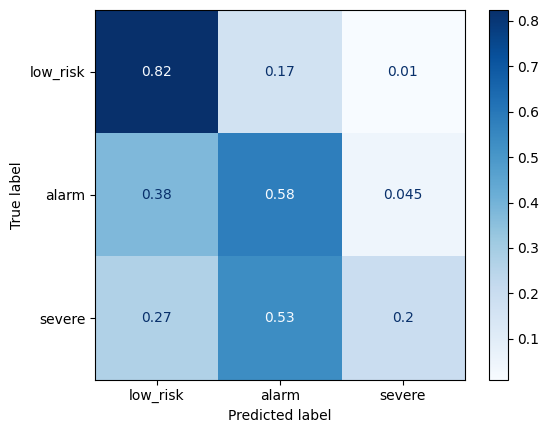

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_final_test, y_pred_final_test, display_labels=target_names, cmap=plt.cm.Blues, normalize='true')

plt.savefig("optimized_clf_confusion_matrix.pdf")
plt.show()

In [ ]:
def plot_metrics_by_class(y_true, y_pred, target_names, figsize=(10, 6)):
    # Obter report como dicionário
    report_dict = classification_report(y_true, y_pred, target_names=target_names,
                                       zero_division=0, output_dict=True)

    # Criar figura
    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(target_names))
    width = 0.25

    # Preparar dados
    precision_values = [report_dict[cls]['precision'] for cls in target_names]
    recall_values = [report_dict[cls]['recall'] for cls in target_names]
    f1_values = [report_dict[cls]['f1-score'] for cls in target_names]

    # Criar barras
    bars1 = ax.bar(x - width, precision_values, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recall_values, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1_values, width, label='F1-Score', alpha=0.8)

    # Adicionar valores no topo das barras
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)

    # Configurar gráfico
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.set_title('Classification Metrics by Class', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(target_names)
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()

    return fig, ax, report_dict

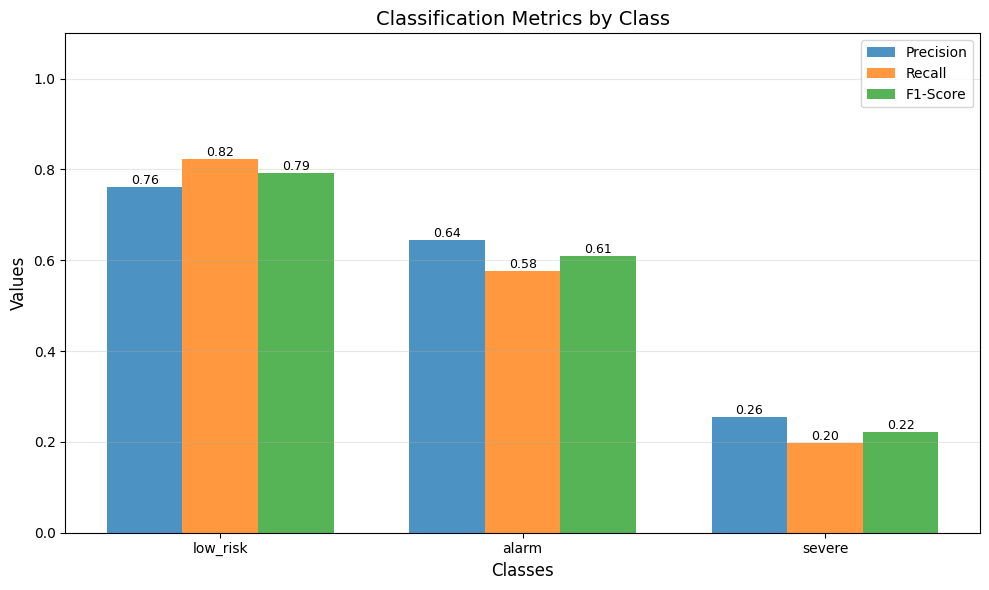

In [ ]:
fig, ax, report_dict = plot_metrics_by_class(y_final_test, y_pred_final_test, target_names=target_names)

plt.savefig("optimized_clf_metrics_by_class.pdf")
plt.show()

## Interpretação dos Resultados com SHAP

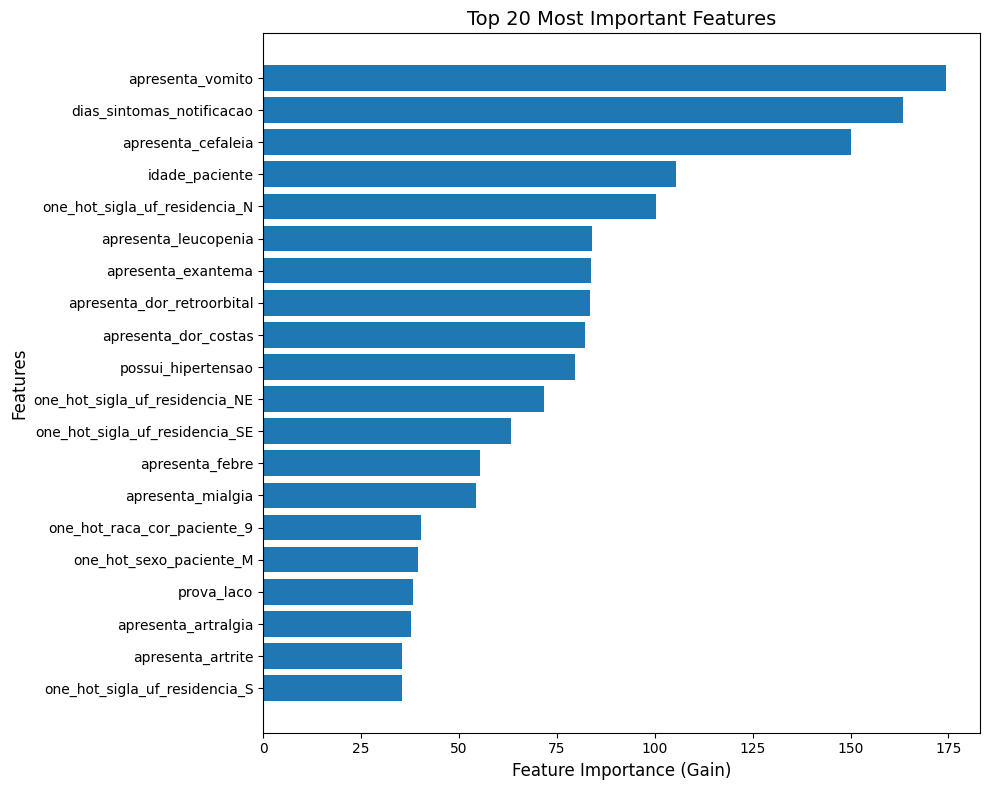


Top 10 Most Important Features:
                      feature  importance
           possui_hipertensao   79.560432
         apresenta_dor_costas   82.235321
   apresenta_dor_retroorbital   83.476181
           apresenta_exantema   83.589722
         apresenta_leucopenia   83.934761
one_hot_sigla_uf_residencia_N  100.351944
               idade_paciente  105.332466
           apresenta_cefaleia  150.102097
    dias_sintomas_notificacao  163.283279
             apresenta_vomito  174.349106


In [ ]:
importance_dict = model_final.get_booster().get_score(importance_type='gain')

feature_importance = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values('importance', ascending=True)

feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}
feature_importance['feature'] = feature_importance['feature'].map(lambda x: feature_map.get(x, x))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].tail(20), feature_importance['importance'].tail(20))
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=14)
plt.tight_layout()
plt.savefig("optimized_clf_feature_importance.pdf")
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.tail(10).to_string(index=False))